Loading the libraries and dependencies

In [2]:
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


reading the csv file

In [3]:

data = pd.read_csv('google_drive_nanreplaced.csv')

In [4]:

data.head()

,time,1day_active_users,1day_google_documents_active_users,1day_google_drawings_active_users,1day_google_forms_active_users,1day_google_presentations_active_users,1day_google_sites_active_users,1day_google_spreadsheets_active_users,1day_other_types_active_users,30day_active_users,...,owned_items_with_visibility_unknown_delta,owned_items_with_visibility_unknown_removed,owned_other_types_added,owned_other_types_created,owned_other_types_delta,owned_other_types_edited,owned_other_types_removed,owned_other_types_trashed,owned_other_types_viewed,sharers
0,2017-03-12 05:00:00,1543.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,3509.0,0.0,193.0,0.0,173.0,1173.0,0.0
1,2017-03-14 04:00:00,2495.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,6275.0,0.0,837.0,0.0,1018.0,1759.0,0.0
2,2017-03-16 04:00:00,2403.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,22084.0,0.0,820.0,0.0,805.0,1451.0,0.0
3,2017-03-19 04:00:00,2848.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,51355.0,0.0,725.0,0.0,737.0,1247.0,0.0
4,2017-03-20 04:00:00,5302.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,9979.0,0.0,1330.0,0.0,924.0,2339.0,0.0


Creating a function named Pick up number which takes in different attributes fo rthe predictive analysis in fb prophet.

In [5]:
def pick_your_number(number):
    if (number == 1):
        df=data[['time','1day_active_users','30day_active_users']]
        print("you picked google drive 1day active users and 30 day active users")
    if (number == 2):
        df=data
        print("you picked the entire data set")
    if (number ==3):
        df= data[['time','google_forms_created','google_forms_edited','1day_active_users','30day_active_users']]
        print("you picked 5 attributes")
    #else:
        #df=[]
        #print("you didn't pick any dataset")
    return df

Create a function named time set which gives the time from which to which we need the predictions to be done

In [6]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df

the function to plot the predictions of the fb prophets for the selected attributes

In [7]:
def plot(df,df0):
    df1=df.copy()
    df2= df0.copy()
    df1= time_set(df1)
    df2= time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22,10))
        plt.plot(df1.index, df1[df1.columns[x]], label= df1.columns[x])
        plt.plot(df2.index,df2[df2.columns[x]], label= 'prophet', color='r')
        plt.legend(loc= 'best', fontsize='xx-large')
        plt.show()

A function to do the time series prediction That calls the fb prophet model and fit the model for our data, display the results

In [8]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True,  changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())
    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

the function time prediction mape gives the error values for the given attributes, the errors are mape, mse. rmse etc

In [9]:
#mean absolute percent error
def timepredictionMAPE(df,csvfilename):
    p = Prophet(daily_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [10]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [11]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

We have selected the attributes in our data set by calling the function pick_your_number

In [12]:
five_att = pick_your_number(1)

you picked google drive 1day active users and 30 day active users


The perdiction function was called to see the prediction for 2020 and various measures that shows th errors and accuracies.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for 1day_active_users
  horizon           mse         rmse         mae      mape  coverage
0 36 days  1.081352e+06  1039.880787  875.224594  0.202335  0.583333
1 37 days  1.081517e+06  1039.960091  876.665535  0.202424  0.583333
2 38 days  1.129688e+06  1062.868023  908.423908  0.205646  0.555556
3 39 days  1.160034e+06  1077.048687  923.469681  0.206645  0.527778
4 40 days  1.161957e+06  1077.940862  924.487783  0.205968  0.527778
Performance tail for 1day_active_users
     horizon           mse         rmse          mae      mape  coverage
321 361 days  1.809902e+06  1345.325851  1201.008754  0.474510  0.861111
322 362 days  1.859509e+06  1363.638249  1217.896472  0.467126  0.861111
323 363 days  1.874035e+06  1368.953954  1222.601535  0.465662  0.861111
324 364 days  1.940756e+06  1393.110362  1249.998493  0.475857  0.861111
325 365 days  2.014303e+06  1419.261505  1280.046076  0.499167  0.861111


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


Performance head for 30day_active_users
  horizon            mse        rmse         mae      mape  coverage
0 36 days  892745.265901  944.851981  766.564284  0.044059  0.972222
1 37 days  913438.402374  955.739715  781.341436  0.044688  0.972222
2 38 days  931300.408520  965.039071  796.153700  0.045353  0.972222
3 39 days  946334.176957  972.797089  807.190942  0.045776  0.972222
4 40 days  958265.318539  978.910271  815.322124  0.046040  0.972222
Performance tail for 30day_active_users
     horizon           mse         rmse          mae      mape  coverage
321 361 days  2.432624e+07  4932.163880  4634.605603  0.333913       1.0
322 362 days  2.409534e+07  4908.700190  4613.843388  0.330405       1.0
323 363 days  2.400416e+07  4899.404218  4605.711310  0.327946       1.0
324 364 days  2.588159e+07  5087.394824  4761.933304  0.341596       1.0
325 365 days  2.784592e+07  5276.922994  4924.376374  0.355719       1.0


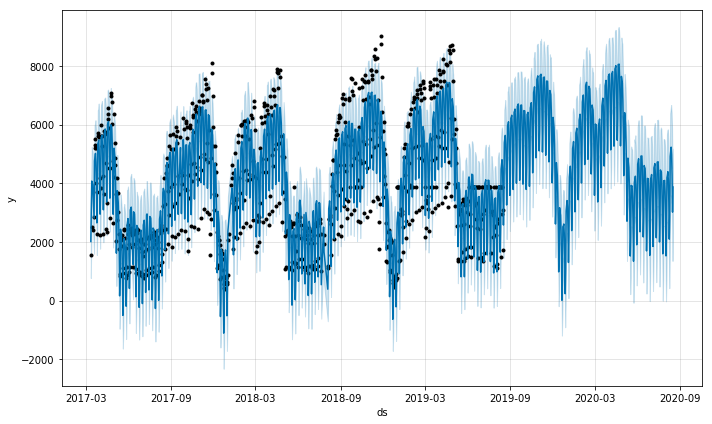

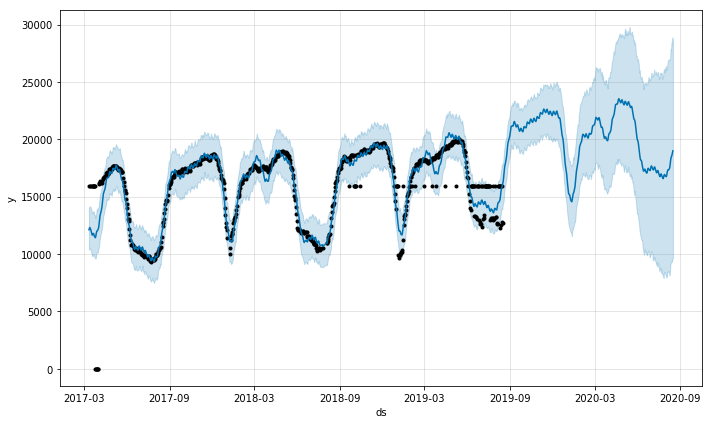

In [13]:
prediction = send_prediction(five_att)

The send_predictionMape function when a attributes are provided plot the mape error values across time.

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


MAPE for 1day_active_users predictions


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


MAPE for 30day_active_users predictions


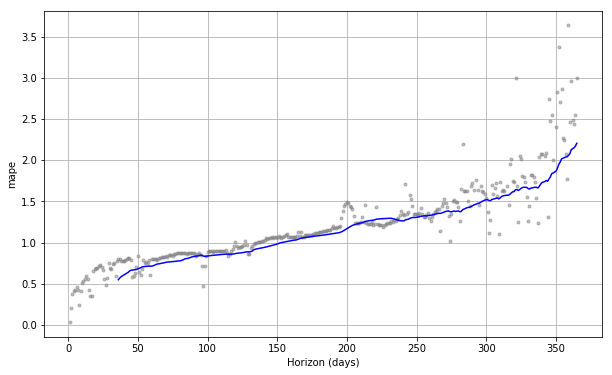

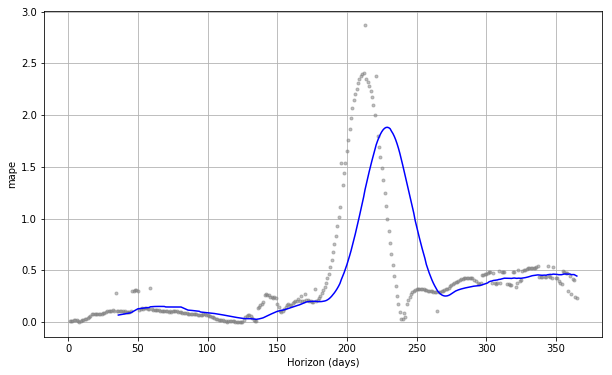

In [14]:

prediction1 = send_predictionMAPE(five_att)

In [15]:
df1= data[['time','1day_active_users']]
df1 = df1.rename(columns={df1.columns[0]: "ds", df1.columns[1]: "y"})

In [16]:
df1.head()

,ds,y
0,2017-03-12 05:00:00,1543.0
1,2017-03-14 04:00:00,2495.0
2,2017-03-16 04:00:00,2403.0
3,2017-03-19 04:00:00,2848.0
4,2017-03-20 04:00:00,5302.0


In [17]:
m=Prophet()
m.fit(df1)

In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1191,2020-08-12 04:00:00
1192,2020-08-13 04:00:00
1193,2020-08-14 04:00:00
1194,2020-08-15 04:00:00
1195,2020-08-16 04:00:00


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1191,2020-08-12 04:00:00,5300.436513,4174.608181,6490.159963
1192,2020-08-13 04:00:00,5046.861323,3874.215832,6178.846250
1193,2020-08-14 04:00:00,4385.109464,3281.864507,5582.339238
1194,2020-08-15 04:00:00,3103.387597,1916.627363,4314.824351
1195,2020-08-16 04:00:00,3924.802790,2803.172403,5064.386693


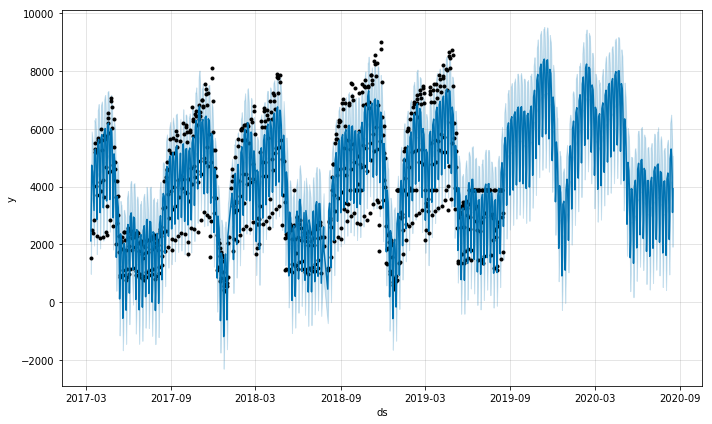

In [20]:
fig1 = m.plot(forecast)

The fb prophet function plot components gives the trends in our predicted data

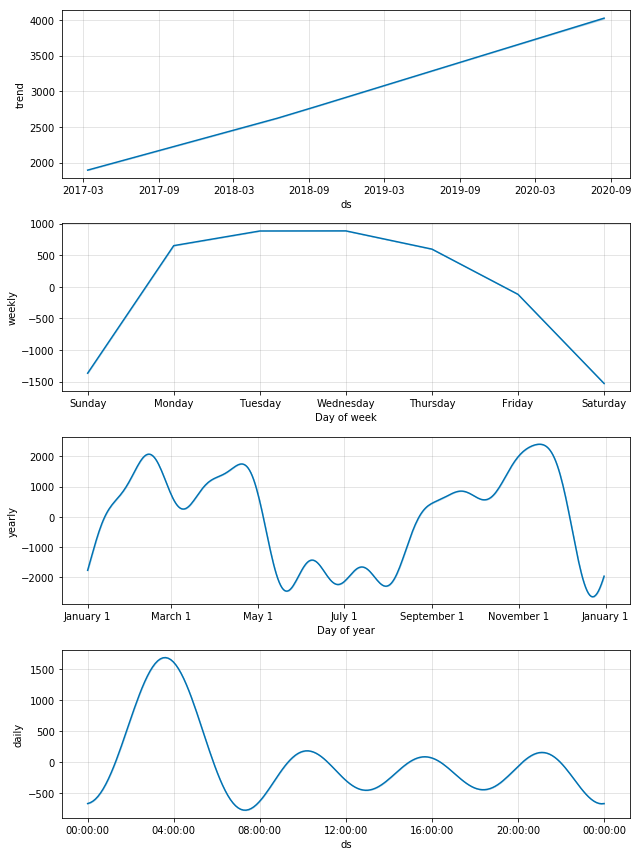

In [21]:
fig2 = m.plot_components(forecast)

In [22]:
cross_validation_results = cross_validation(m, initial='210 days', period='15 days', horizon='70 days')
print(cross_validation_results)

INFO:fbprophet:Making 41 forecasts with cutoffs between 2017-10-16 04:00:00 and 2019-06-08 04:00:00


                      ds          yhat    yhat_lower    yhat_upper  \
0    2017-10-17 04:00:00   6640.717198   5907.913069   7367.767494   
1    2017-10-18 04:00:00   7182.267866   6500.426063   7844.799744   
2    2017-10-19 04:00:00   7454.832393   6697.880170   8130.383166   
3    2017-10-20 04:00:00   7179.845236   6463.267836   7860.639618   
4    2017-10-21 04:00:00   6398.893339   5686.710647   7094.296976   
5    2017-10-22 04:00:00   7754.721870   7010.980252   8510.106866   
6    2017-10-23 04:00:00  10051.612040   9306.240218  10745.526317   
7    2017-10-24 04:00:00  10844.506304  10141.818023  11523.577623   
8    2017-10-25 04:00:00  11643.150411  11005.865154  12374.720880   
9    2017-10-26 04:00:00  12120.964045  11418.751664  12840.179327   
10   2017-10-27 04:00:00  11991.625740  11309.055431  12711.051125   
11   2017-10-28 04:00:00  11289.817460  10566.768839  12000.815862   
12   2017-10-29 04:00:00  12652.432849  11975.540588  13376.435539   
13   2017-10-30 04:0

In [23]:
forecast=forecast.to_csv( '1day_active_users_prediction.csv', index = False)

In [24]:
df2= data[['time','30day_active_users']]
df2 = df2.rename(columns={df2.columns[0]: "ds", df2.columns[1]: "y"})

In [25]:
df2.head()

,ds,y
0,2017-03-12 05:00:00,15955.695538
1,2017-03-14 04:00:00,15955.695538
2,2017-03-16 04:00:00,15955.695538
3,2017-03-19 04:00:00,15955.695538
4,2017-03-20 04:00:00,15955.695538


In [26]:
m=Prophet()
m.fit(df2)

In [27]:

future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1191,2020-08-12 04:00:00
1192,2020-08-13 04:00:00
1193,2020-08-14 04:00:00
1194,2020-08-15 04:00:00
1195,2020-08-16 04:00:00


In [28]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1191,2020-08-12 04:00:00,18899.669326,16902.938295,21002.932590
1192,2020-08-13 04:00:00,18968.983574,16821.588494,20939.262218
1193,2020-08-14 04:00:00,19138.558608,17017.843164,21170.054712
1194,2020-08-15 04:00:00,19319.744030,17283.369106,21600.746409
1195,2020-08-16 04:00:00,19484.262868,17340.295480,21512.482366


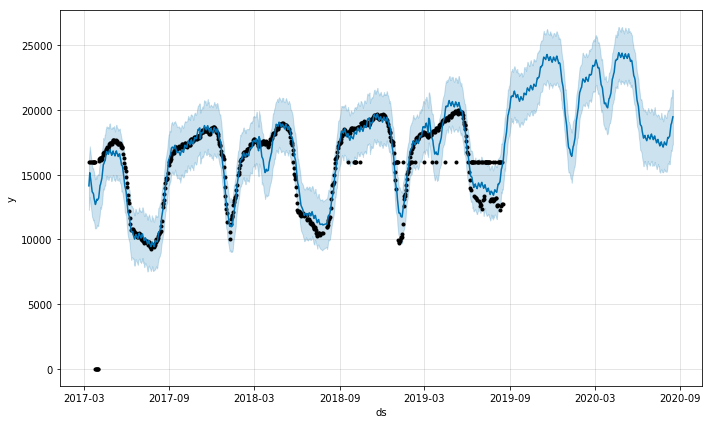

In [29]:
fig1 = m.plot(forecast)

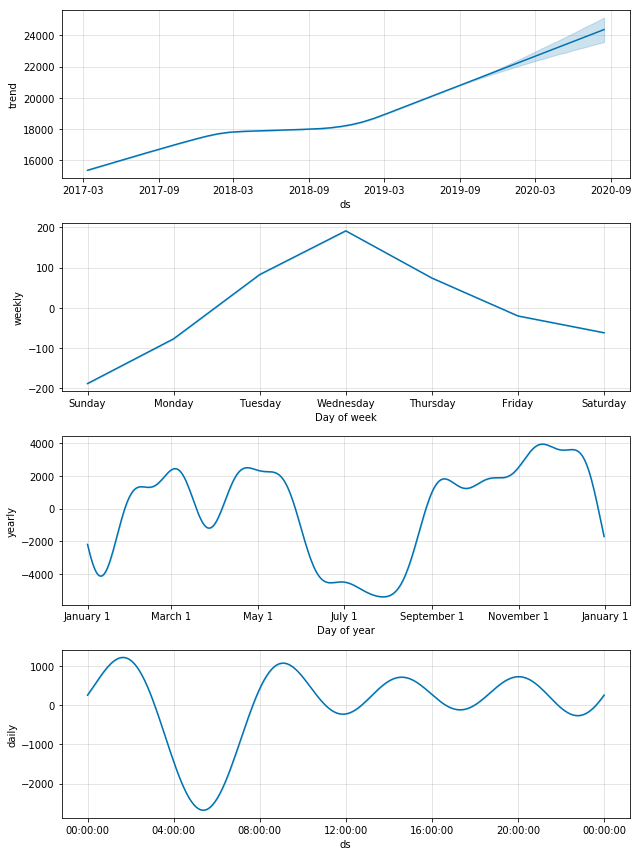

In [30]:
fig2 = m.plot_components(forecast)

In [31]:

cross_validation_results = cross_validation(m, initial='210 days', period='15 days', horizon='70 days')
print(cross_validation_results)

INFO:fbprophet:Making 41 forecasts with cutoffs between 2017-10-16 04:00:00 and 2019-06-08 04:00:00


                      ds          yhat    yhat_lower    yhat_upper  \
0    2017-10-17 04:00:00  18898.272855  16159.812154  21601.748469   
1    2017-10-18 04:00:00  19633.710910  17005.272100  22397.853728   
2    2017-10-19 04:00:00  20079.163348  17264.757982  22708.564690   
3    2017-10-20 04:00:00  20746.236177  17936.029688  23414.053851   
4    2017-10-21 04:00:00  21280.299025  18650.401996  23831.835702   
5    2017-10-22 04:00:00  21930.621348  19278.962518  24914.403000   
6    2017-10-23 04:00:00  22808.012139  20035.444463  25542.500770   
7    2017-10-24 04:00:00  23432.941863  20525.917172  26108.367352   
8    2017-10-25 04:00:00  24286.375710  21772.858519  26887.663263   
9    2017-10-26 04:00:00  24756.894494  22038.150076  27615.491845   
10   2017-10-27 04:00:00  25348.292002  22545.512552  28063.198655   
11   2017-10-28 04:00:00  25700.324578  22941.361894  28408.248573   
12   2017-10-29 04:00:00  26059.117943  23350.115092  28749.632320   
13   2017-10-30 04:0

In [32]:
forecast=forecast.to_csv( '30day_active_users_prediction.csv', index = False)